In [ ]:
import pandas as pd
import numpy as np
import tejapi
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
tej_key ='your tej key'
tejapi.ApiConfig.api_key = tej_key
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key


from zipline.sources.TEJ_Api_Data import get_universe
import TejToolAPI
from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record, order_target_percent
from zipline.finance import commission, slippage
from zipline import run_algorithm
from scipy.optimize import minimize

In [6]:
start_date = '2010-01-01'; end_date = '2025-04-21'

pool = get_universe(start = start_date,
                      end = end_date,
                      mkt_bd_e = ['TSE', 'OTC'],
                      stktp_e = 'Common Stock',
                      main_ind_e = 'General Industry')

columns = ['coid','bstl', 'bsse', 'fld005', 'close_d', 'per', 'pbr_tej', 'shares', 'cscfo', 'cscfi', 'cscff']

start_dt = pd.Timestamp(start_date, tz = 'UTC')
end_dt = pd.Timestamp(end_date, tz = "UTC")

data_use = TejToolAPI.get_history_data(start = start_dt,
                                    end = end_dt,
                                    ticker = pool,
                                    fin_type = 'Q', # 為累計資料
                                    columns = columns,
                                    transfer_to_chinese = False)

Currently used TEJ API key call quota 129/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 28688140/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 247/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 35056686/9223372036854775807 (0.0%)


In [8]:
# 確保時間格式正確
data_use['mdate'] = pd.to_datetime(data_use['mdate'])

# 計算 Total_cashflow
data_use['Total_cashflow'] = data_use['Cash_Flow_from_Operating_Activities_Q']

# 排序
data_use = data_use.sort_values(['coid', 'mdate'])

# 轉成季資料：每股公司取每季最後一筆
df_q = data_use.set_index('mdate').groupby('coid', group_keys=False).resample('Q').last().reset_index()

# 計算近四季平均本益比
df_q['PER_4Q_avg'] = df_q.groupby('coid')['PER_TWSE'].transform(lambda x: x.rolling(4, min_periods=4).mean())

# 計算近四季總現金流
df_q['Cashflow_4Q_sum'] = df_q.groupby('coid')['Total_cashflow'].transform(lambda x: x.rolling(4, min_periods=4).sum())

# 計算「股價 / 現金流」：若現金流為 0，則設為 NaN 避免除以 0
df_q['Price_to_CF'] = (df_q['Close'] * df_q['Issue_Shares_1000_Shares']) / df_q['Cashflow_4Q_sum'].replace(0, np.nan)

# 市場平均本益比 & 市場平均 Price_to_CF
df_q['Market_PER_avg'] = df_q.groupby('mdate')['PER_TWSE'].transform('mean')
df_q['Market_PCF_avg'] = df_q.groupby('mdate')['Price_to_CF'].transform('mean')

# 判斷是否低於市場平均
df_q['PER_below_market'] = df_q['PER_4Q_avg'] < df_q['Market_PER_avg']
df_q['PCF_below_market'] = df_q['Price_to_CF'] < df_q['Market_PCF_avg']

# 確保排序
data_use = data_use.sort_values(['coid', 'mdate'])
df_q = df_q.sort_values(['coid', 'mdate'])

# 用 merge_asof 把季資料合併回每日
result_list = []

for coid, df_daily_group in data_use.groupby('coid'):
    df_q_group = df_q[df_q['coid'] == coid]

    merged = pd.merge_asof(
        df_daily_group,
        df_q_group[['mdate', 'PER_below_market', 'PCF_below_market']],
        on='mdate',
        direction='backward'
    )
    result_list.append(merged)

# 合併所有公司
data_final = pd.concat(result_list).sort_values(['coid', 'mdate']).reset_index(drop=True)


In [11]:
def compute_stock(date, data):
    df = data[data['mdate'] == pd.to_datetime(date)].reset_index(drop = True)

    df['debt_equity_ratio'] = df['Total_Liabilities_Q'] / df['Total_Equity_Q']
    set_1 = set(df[df['debt_equity_ratio'] < .4]['coid'])

    Director_avg = df['Director_and_Supervisor_Holdings_Percentage'].mean()
    set_2 = set(df[df['Director_and_Supervisor_Holdings_Percentage'] > Director_avg]['coid'])

    set_3 = set(df[df['PER_below_market'] == True]['coid'])

    set_4 = set(df[df['PCF_below_market'] == True]['coid'])

    PBR_avg = df['PBR_TEJ'].mean()
    set_5 = set(df[df['PBR_TEJ'] < PBR_avg]['coid'])

    set_6 = set(df[df['PBR_TEJ'] < 1.0]['coid'])

    tickers = list(set_1 & set_2 & set_5 & set_6 & set_3 & set_4)


    return tickers

In [5]:
pools = pool + ['IR0001']

start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

print(f'開始匯入回測資料')
simple_ingest(name = 'tquant' , tickers = pools , start_date = start_ingest , end_date = end_ingest)
print(f'結束匯入回測資料')

開始匯入回測資料
Now ingesting data.


[2025-04-29 01:02:24.655955] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 128/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 23130188/9223372036854775807 (0.0%)


[2025-04-29 01:06:35.033341] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20100101', tz = 'utc'),end_dt = pd.Timestamp('20250421' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 128/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 23130188/9223372036854775807 (0.0%)
結束匯入回測資料


In [12]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))

    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []


def handle_data_1(context, data, rebalance = 60):
    # 避免前視偏誤，在篩選股票下一交易日下單
    if context.state == True:

        for i in context.last_tickers:
            if i not in context.order_tickers:
                order_target_percent(symbol(i), 0)


        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

            curr = data.current(symbol(i), 'price')
            record(price = curr, days = context.i)

        print(f"下單日期：{data.current_dt.date()}, 擇股股票數量：{len(context.order_tickers)}, Leverage: {context.account.leverage}")


        context.last_tickers = context.order_tickers.copy()
        context.state = False

    backtest_date = data.current_dt.date()

    if context.i % rebalance == 0:
        context.state = True
        context.order_tickers = compute_stock(date = backtest_date, data = data_final)


    record(Leverage = context.account.leverage)
    if context.account.leverage > 1.2:
        print(f'{data.current_dt.date()}: Over Leverage, Leverage: {context.account.leverage}')
        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

    context.i += 1


In [39]:
def test(context, data):
    if context.i == 0:
        order_target_percent(symbol('IR0001'), 1.0)

    context.i += 1


def ana_test(context, perf):
    pass

下單日期：2020-01-03, 擇股股票數量：20, Leverage: 0.0
下單日期：2020-04-10, 擇股股票數量：28, Leverage: 0.9462527312299922
下單日期：2020-07-08, 擇股股票數量：19, Leverage: 0.9961893163396446
下單日期：2020-09-30, 擇股股票數量：17, Leverage: 0.9776219546095151
下單日期：2020-12-28, 擇股股票數量：17, Leverage: 0.9975891640434728
下單日期：2021-04-06, 擇股股票數量：13, Leverage: 0.9958934747480133
下單日期：2021-07-01, 擇股股票數量：15, Leverage: 0.9946169218153786
下單日期：2021-09-27, 擇股股票數量：14, Leverage: 0.9805785050680207
下單日期：2021-12-21, 擇股股票數量：11, Leverage: 0.9885835157953479
下單日期：2022-03-28, 擇股股票數量：14, Leverage: 0.9907015492141674
下單日期：2022-06-24, 擇股股票數量：19, Leverage: 1.0038749028345468
下單日期：2022-09-19, 擇股股票數量：7, Leverage: 0.9559949177034098
下單日期：2022-12-13, 擇股股票數量：22, Leverage: 0.993324112783143
下單日期：2023-03-22, 擇股股票數量：9, Leverage: 1.0052888118243832
下單日期：2023-06-20, 擇股股票數量：17, Leverage: 1.0135327848248266
下單日期：2023-09-15, 擇股股票數量：3, Leverage: 0.9779591486168348
下單日期：2023-12-13, 擇股股票數量：4, Leverage: 1.0218864130368177
下單日期：2024-03-19, 擇股股票數量：2, Leverage: 1.007206518338

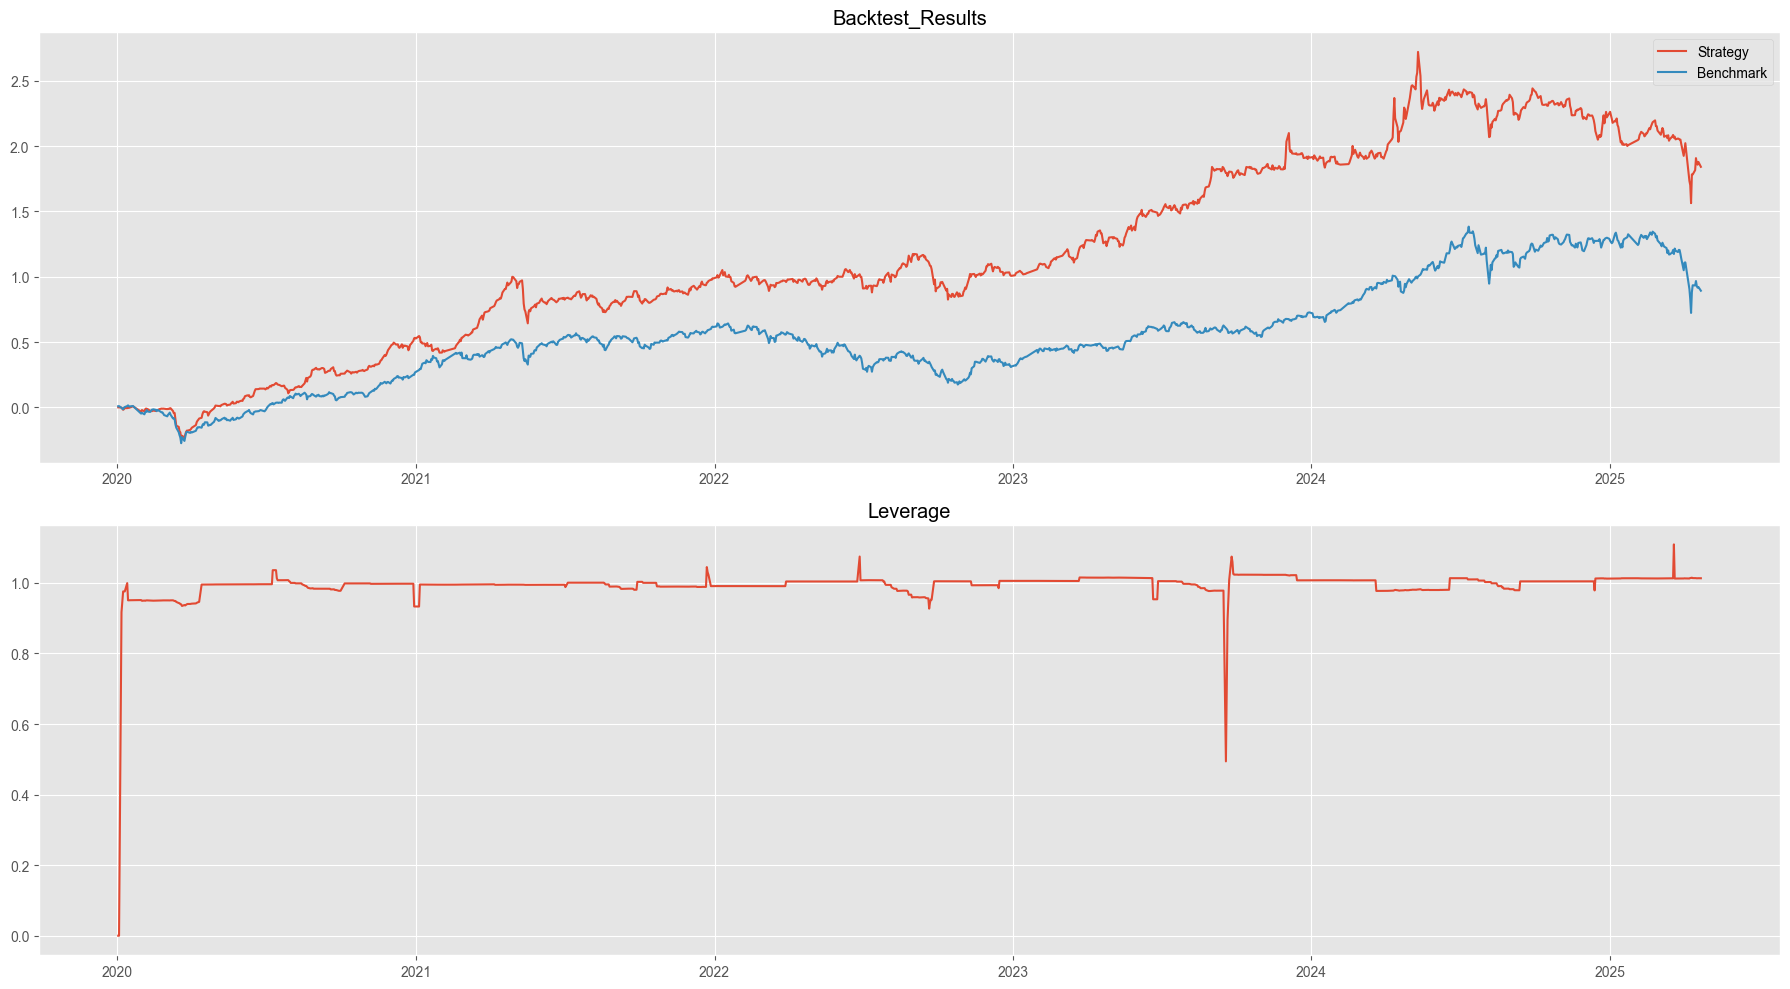

In [16]:
def analyze(context, perf):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)
        plt.style.use('ggplot')
        axes[0].plot(perf.index, perf['algorithm_period_return'], label = 'Strategy')
        axes[0].plot(perf.index, perf['benchmark_period_return'], label = 'Benchmark')
        axes[0].set_title(f"Backtest_Results")
        axes[0].legend()

        axes[1].plot(perf.index, perf['Leverage'], label = 'Leverage')
        axes[1].set_title(f"Leverage")
        axes[1].legend

        plt.tight_layout()
        plt.show()

results = run_algorithm(
            start = pd.Timestamp('2020-01-01', tz = 'utc'),
            end = pd.Timestamp('2025-04-21', tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_1,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e6)

Start date,2020-01-02
End date,2025-04-21
Total months,61
,Backtest
Annual return,22.75%
Cumulative returns,184.175%
Annual volatility,19.524%
Sharpe ratio,1.15
Calmar ratio,0.73
Stability,0.92
Max drawdown,-31.117%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.12,2024-05-10,2025-04-09,NaT,NaN
1,25.53,2020-01-20,2020-03-19,2020-04-30,64
2,17.82,2021-04-28,2021-05-17,2022-01-04,174
3,16.05,2022-08-31,2022-10-13,2023-03-06,121
4,9.96,2024-04-11,2024-04-16,2024-04-30,14


Top 10 long positions of all time,max
sid,
4905,54.69%
2107,50.06%
3306,37.52%
2390,35.84%
1445,35.66%
5438,34.46%
4432,26.09%
2029,25.21%
4706,15.72%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
4905,54.69%
2107,50.06%
3306,37.52%
2390,35.84%
1445,35.66%
5438,34.46%
4432,26.09%
2029,25.21%
4706,15.72%


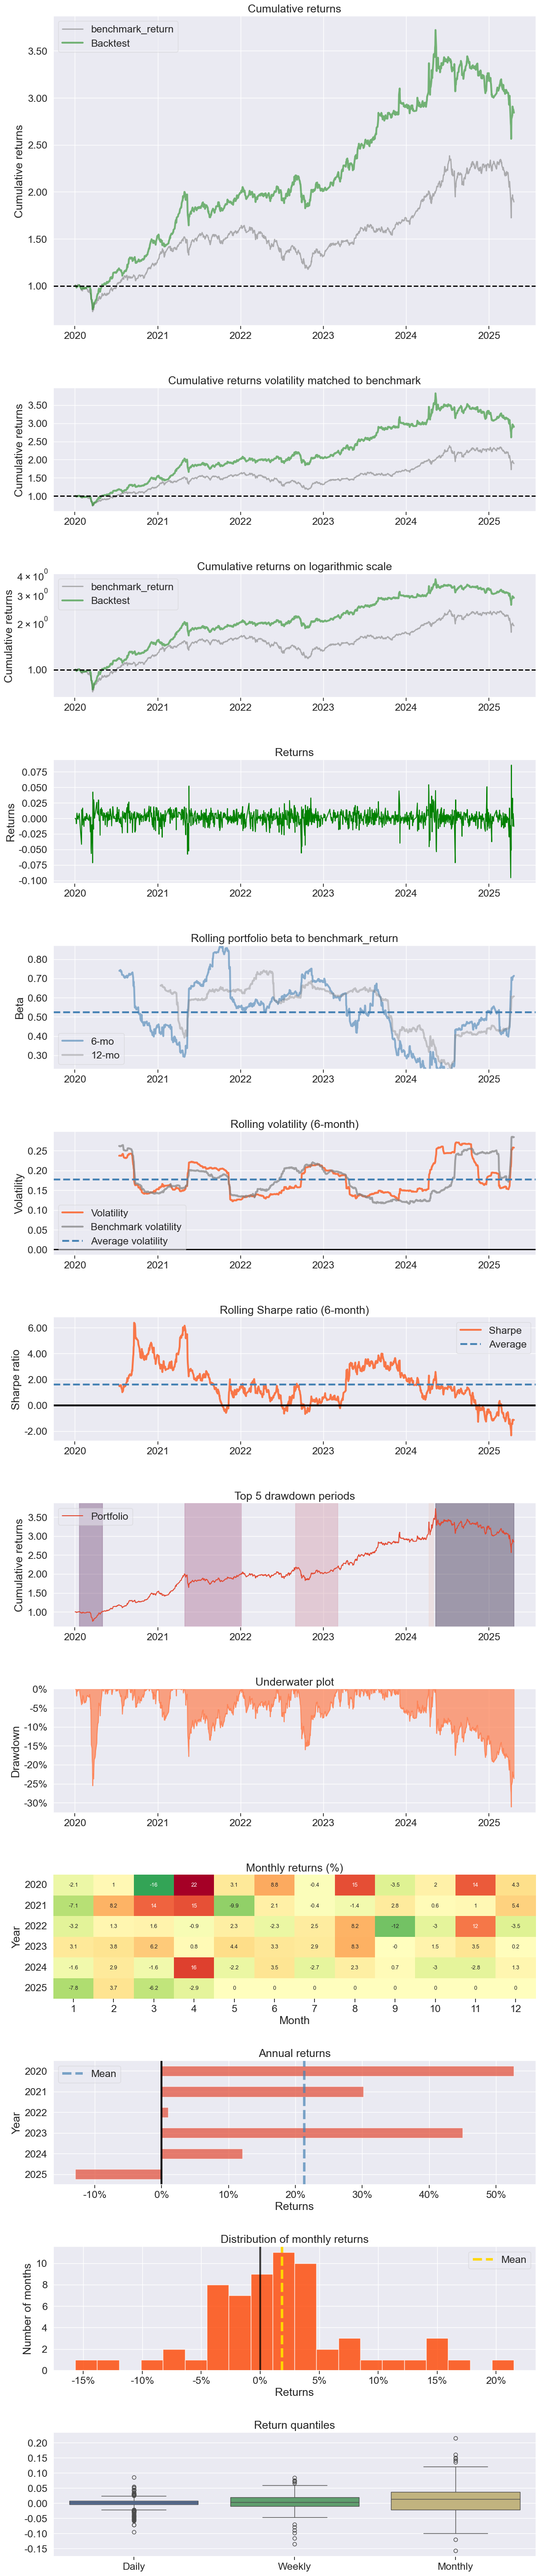

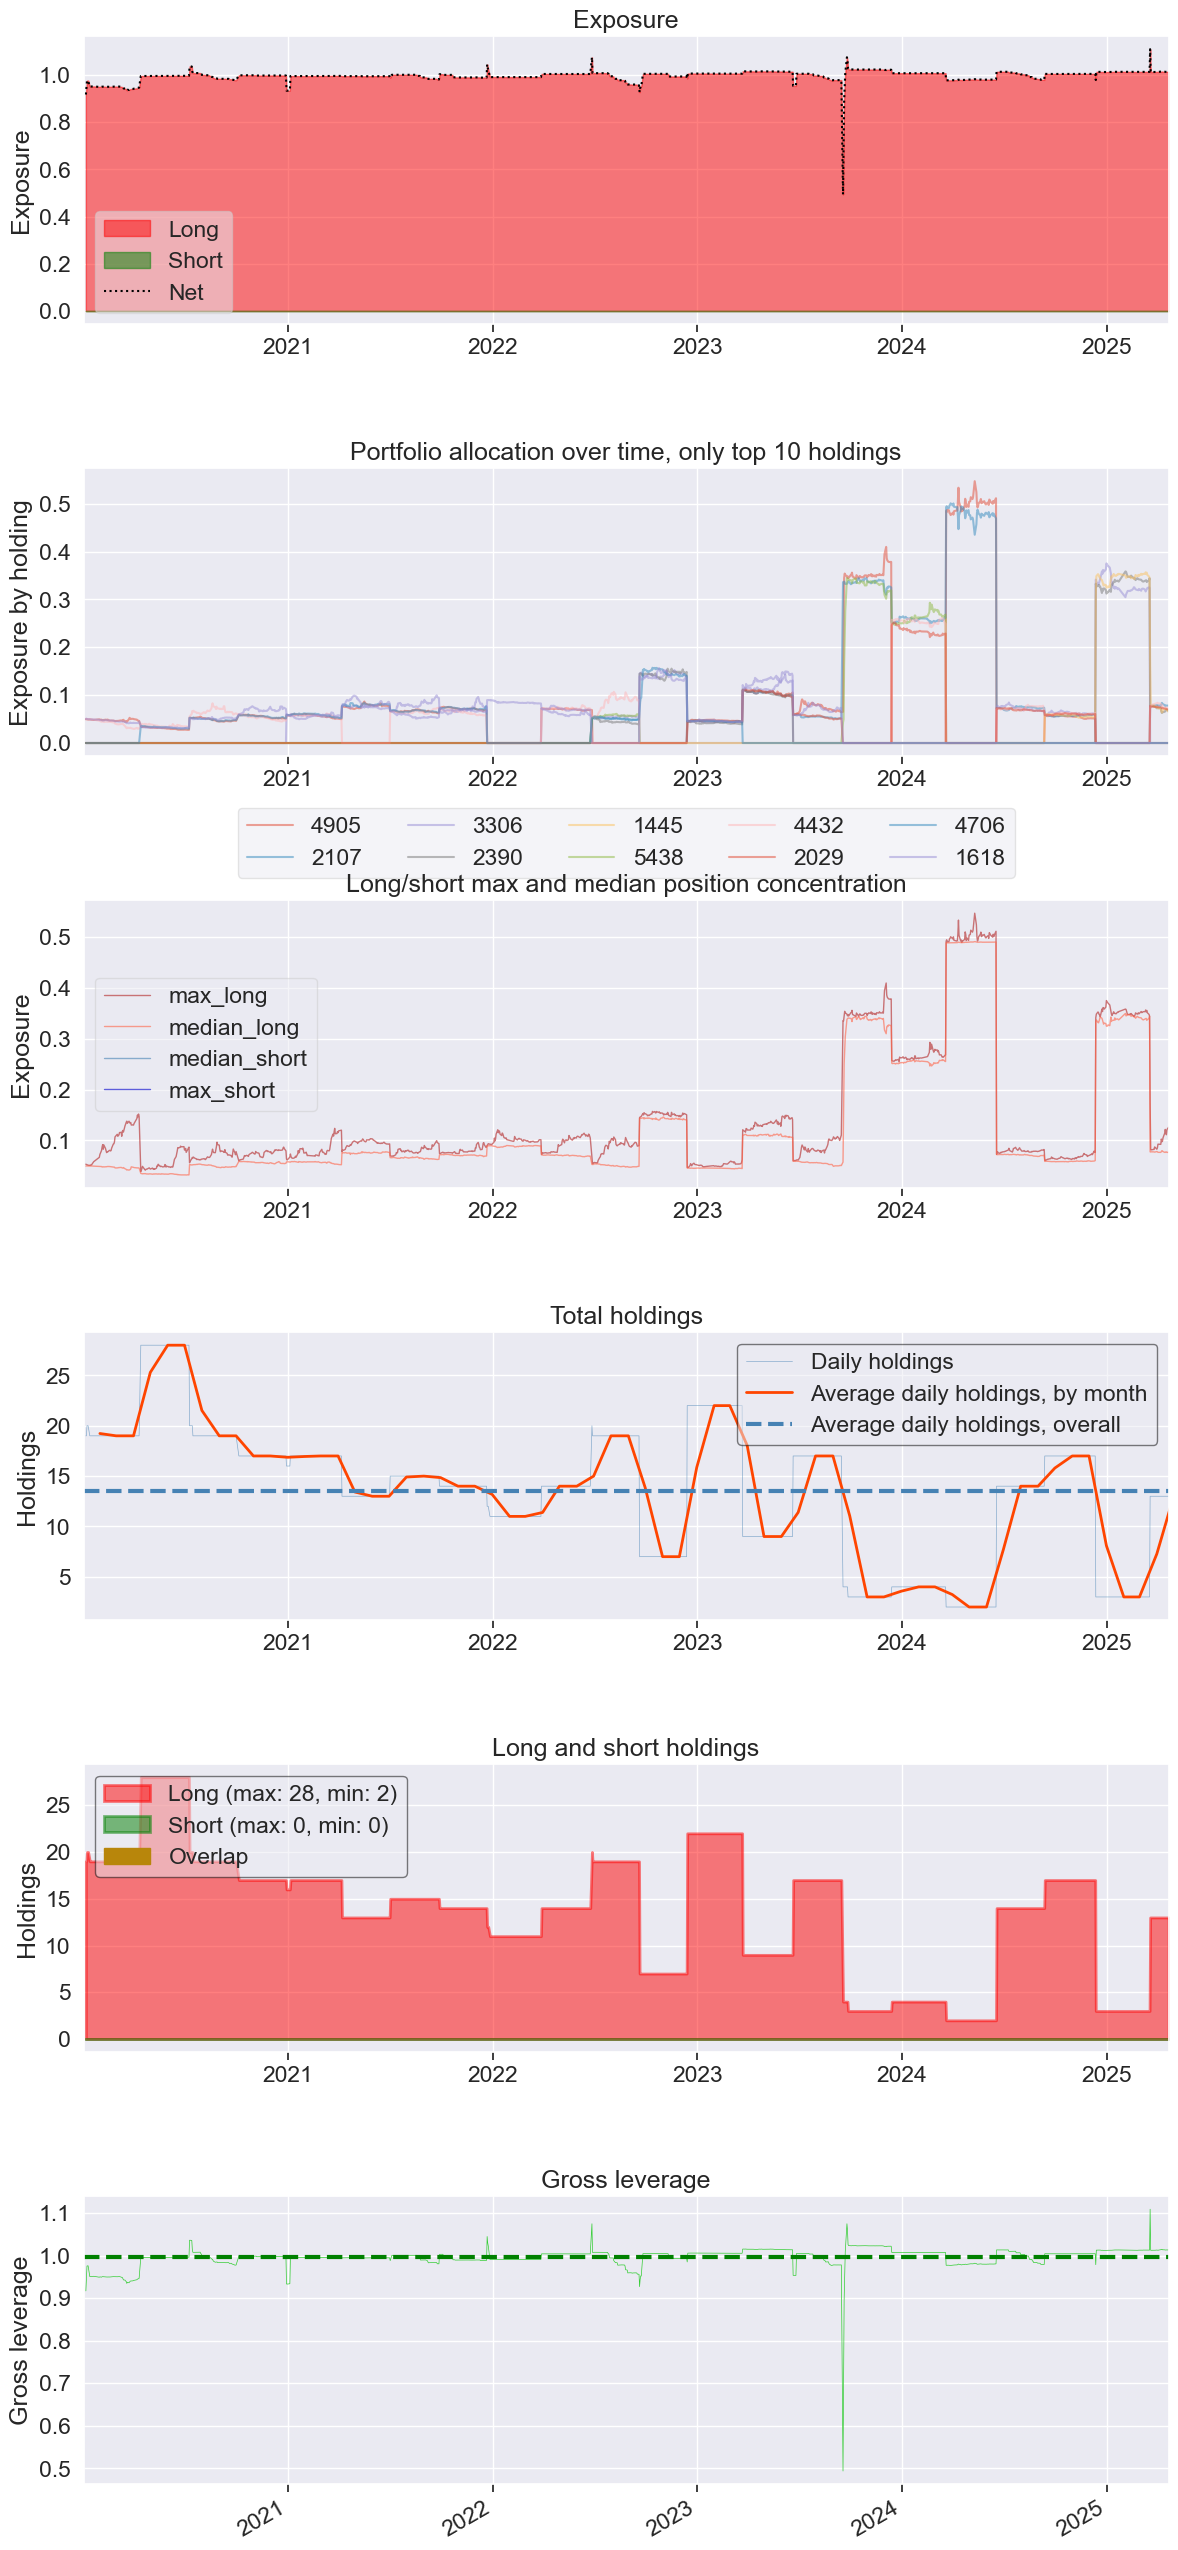

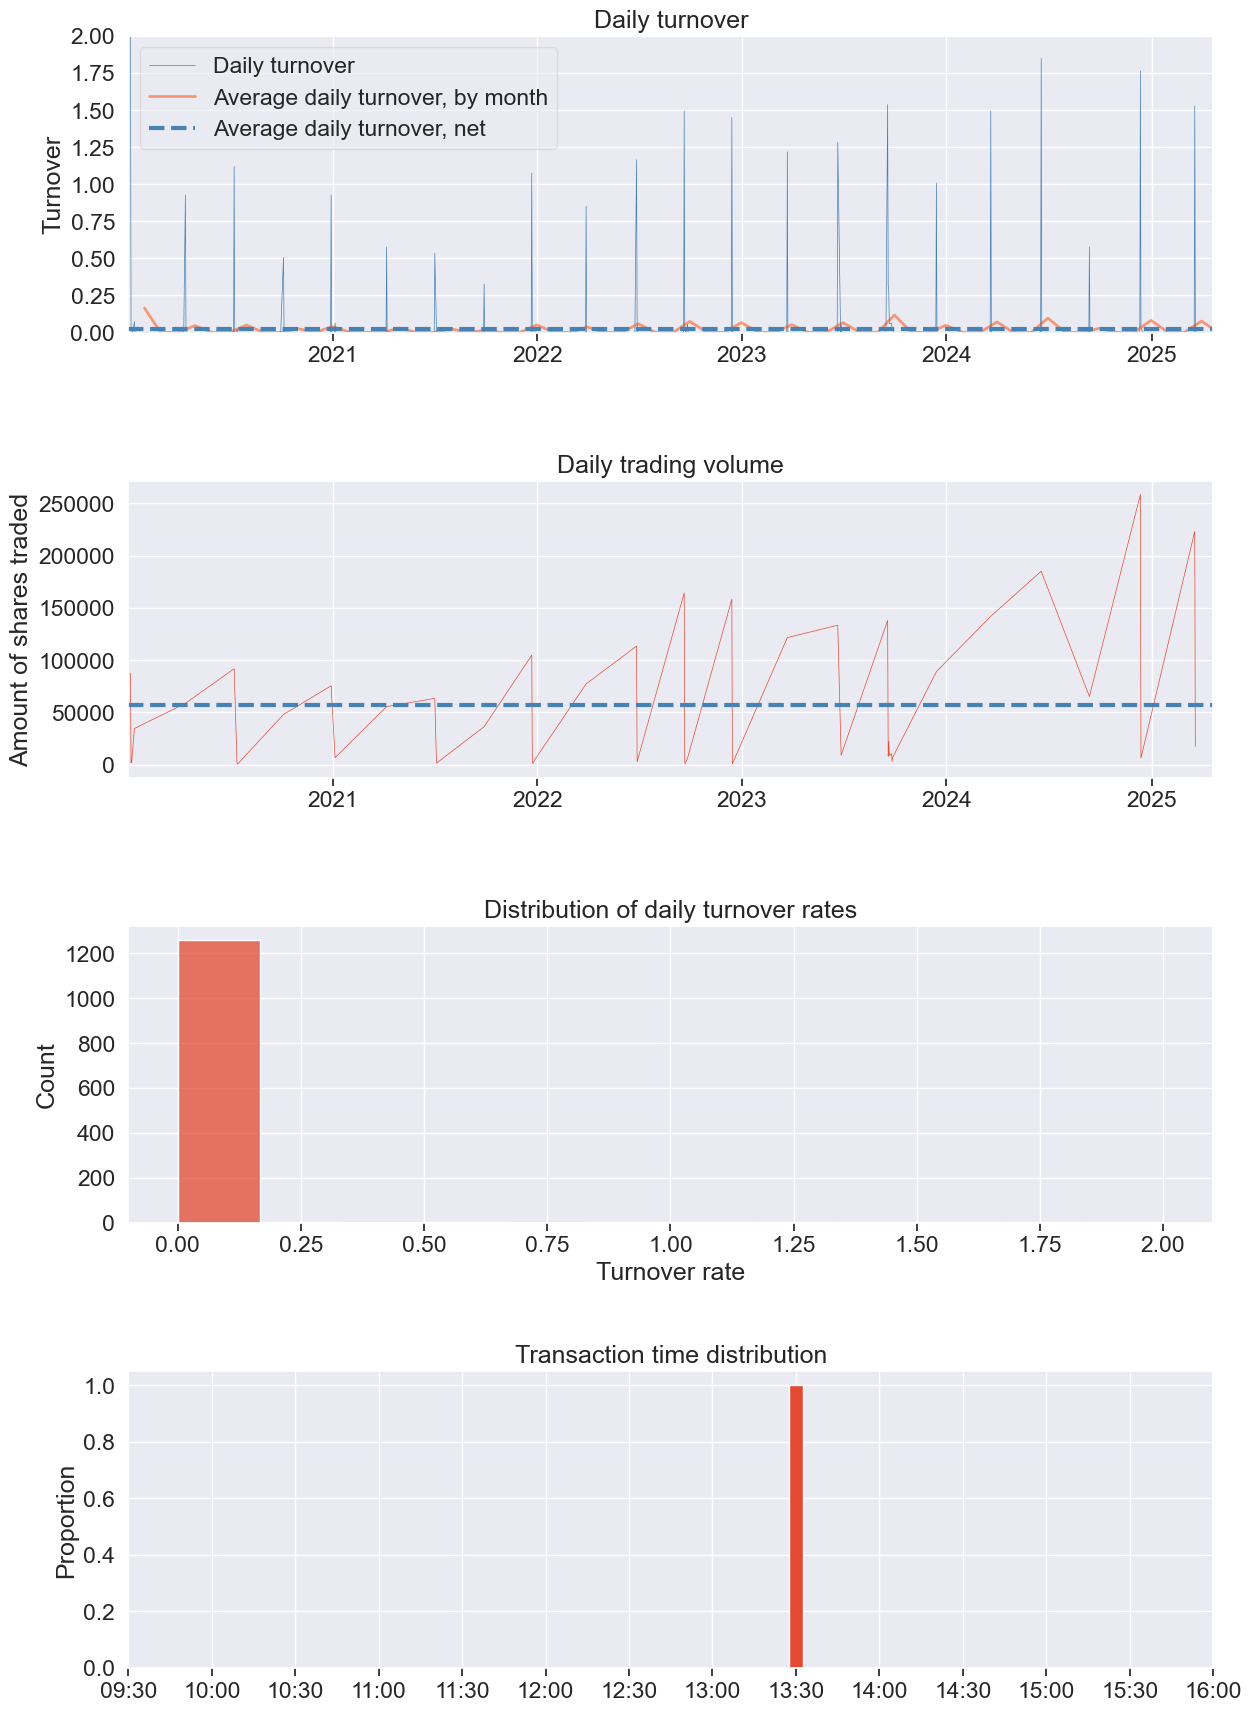

In [19]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )